In [6]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, GlobalAveragePooling1D
from keras.layers import Flatten, Dot
from keras.layers.embeddings import Embedding
from keras.models import Model
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
from tokens_and_glov_embs import get_docs
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, glob

import warnings
warnings.filterwarnings("ignore")

# Process and Visualize Embeddings

### Load GloVe Embedding Matrix and Tokenizer

In [2]:
embedding_matrix = np.load('../preprocessing/glov_emb_matrix.npy')
print('Embedding Matrix:', embedding_matrix.shape)

with open('../preprocessing/tokenizer.pkl', 'rb') as f:
    t = pickle.load(f)

Embedding Matrix: (578207, 100)


### GloVe Embedding Model with 1D Global Average Pooling

In [3]:
vocab_size = 578207
input_length = 10000

# sole glov model
input_tens = Input(shape=(input_length,), name='input_1')
x = Embedding(
    vocab_size, 
    100, 
    input_length=input_length, 
    weights=[embedding_matrix],
    trainable=False
)(input_tens)
#x = Flatten()(x)
x = GlobalAveragePooling1D()(x)

model = Model(inputs=input_tens, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 100)        57820700  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
Total params: 57,820,700
Trainable params: 0
Non-trainable params: 57,820,700
_________________________________________________________________


### Predict Embeddings for all Works

In [7]:
embeddings = np.asarray(()) 
num_data_files = len(glob.glob('../data/Gutenberg/txt/*'))
for d in range(0, num_data_files + 1, 100):
    padded_docs = get_docs('../data/Gutenberg/txt/', t, d, d+100)
    sub_embs = model.predict(padded_docs, verbose=1)
    if embeddings.size == 0:
        embeddings = sub_embs
    else:
        embeddings = np.vstack((embeddings, sub_embs))
    
    print('Embeddings:', embeddings.shape)

100/100 [==============================] - 0s 3ms/step
Embeddings: (100, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (200, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (300, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (400, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (500, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (600, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (700, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (800, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (900, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (1000, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (1100, 100)
100/100 [==============================] - 0s 3ms/step
Embeddings: (1200, 100)
100/100 [==============================] - 0s 3ms/step
Embedd

### UMAP Embeddings for Visualization

In [8]:
umap = UMAP(n_neighbors=20, metric='cosine')
vis_embeddings = umap.fit_transform(embeddings)
print('Vis Embeddings:', vis_embeddings.shape)

Vis Embeddings: (3036, 2)


In [27]:
v2_author_df = pd.read_csv('../preprocessing/v1_author_df.csv')
v2_author_df['umap_1'] = vis_embeddings[:, 0]
v2_author_df['umap_2'] = vis_embeddings[:, 1]
v2_author_df.head(10)

work_id                  author  \
0        0          Thomas_Carlyle   
1        1            Daniel_Defoe   
2        2   James_Fenimore_Cooper   
3        3             Andrew_Lang   
4        4              Mark_Twain   
5        5          Wilkie_Collins   
6        6  Robert_Louis_Stevenson   
7        7            Thomas_Hardy   
8        8    Edgar_Rice_Burroughs   
9        9     Nathaniel_Hawthorne   

                                                work     umap_1    umap_2  
0   History_of_Friedrich_II_of_Prussia,_Appendix.txt -13.398980  0.375710  
1  The_Life,_Adventures_&_Piracies_of_the_Famous_...  -2.697822 -2.966858  
2                              Afloat_And_Ashore.txt   1.164151  0.732139  
3                                Custom_and_Myth.txt   1.721932  2.871000  
4                Goldsmith's_Friend_Abroad_Again.txt -13.249290  0.394274  
5                            The_Queen_of_Hearts.txt   0.461708 -0.220036  
6  The_Works_of_Robert_Louis_Stevenson_-_Swanston...   1.245222 -3.846574  
7                       Under_the_Greenwood_Tree.txt   1.374676 -2.406246  
8                      The_Land_That_Time_Forgot.txt  -0.598880 -3.843706  
9                             A_Bell's_Biography.txt -14.025440  1.224346

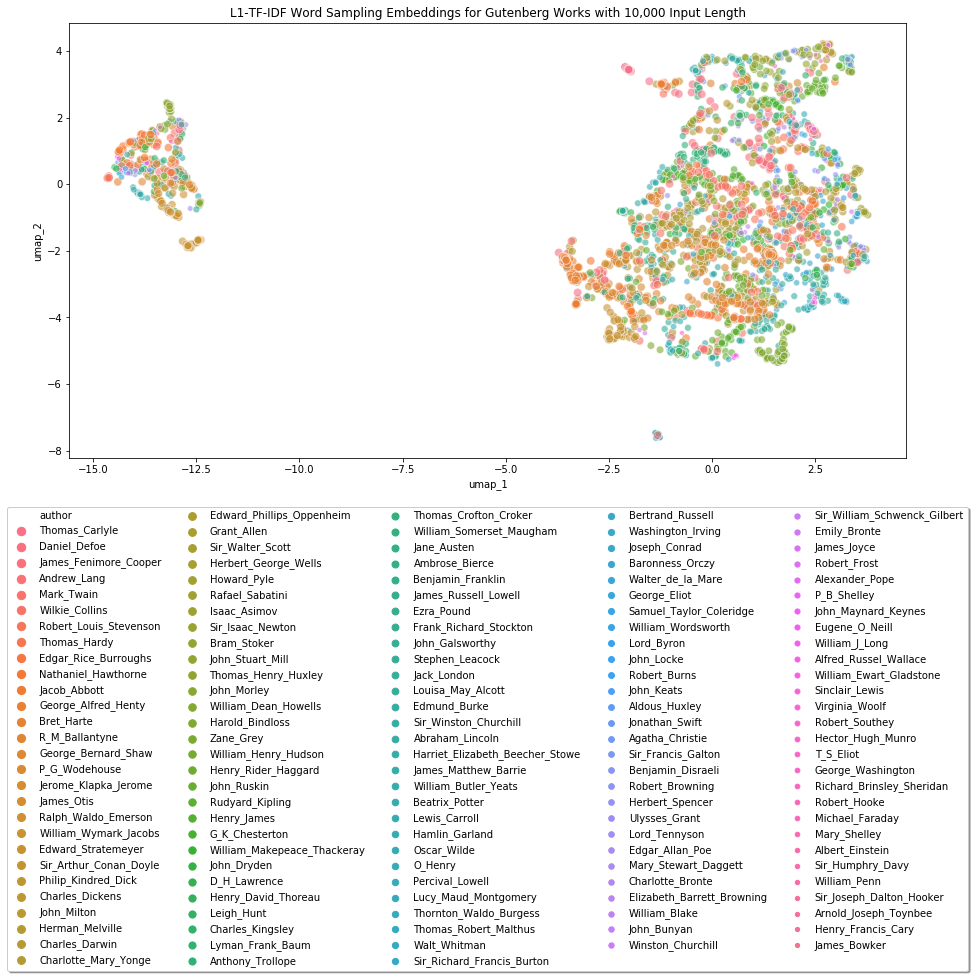

In [28]:
#fig, ax = plt.figure(figsize=(15,8))
v2_subset = v2_author_df[:1000]
fig = plt.figure(figsize=(15,8))
sns.scatterplot(x='umap_1', y='umap_2', hue='author', size='author', data=v2_author_df, alpha=0.6, legend='brief')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          fancybox=True, shadow=True, ncol=5)
plt.title('L1-TF-IDF Word Sampling Embeddings for Gutenberg Works with 10,000 Input Length')
plt.show()

### Plotly Interactive Scatter Plot

In [29]:
fig = px.scatter(v2_author_df, x='umap_1', y='umap_2', color='author',
                 hover_data=['work'])
fig.show()

# Nearest Neighbors for Works

### Neighbors Search on 100-D Embeddings

In [ ]:
#np.save('10000_embeddings.npy', embeddings)

In [30]:
# build data frame with neighbor, author, work
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(embeddings)
distances, inds = neighbors.kneighbors(embeddings)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = v2_author_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(30)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)
#df_neighbors.to_csv('df_neighbors.csv', index=False)

Query_Title           Query_Author  \
56                               Youth.txt           Isaac_Asimov   
1285                             Youth.txt          Joseph_Conrad   
2177         Young_Hunters_of_the_Lake.txt     Edward_Stratemeyer   
90        Young_Folks'_History_of_Rome.txt   Charlotte_Mary_Yonge   
1441   Young_Folks'_History_of_England.txt   Charlotte_Mary_Yonge   
2973                 Young_Auctioneers.txt     Edward_Stratemeyer   
2325                You_Never_Can_Tell.txt    George_Bernard_Shaw   
1922                  Yeast:_A_Problem.txt       Charles_Kingsley   
1930                             Yeast.txt    Thomas_Henry_Huxley   
244                             Xerxes.txt           Jacob_Abbott   
1734                     Wyndham's_Pal.txt        Harold_Bindloss   
2787                         Wyandotte.txt  James_Fenimore_Cooper   
889                  Wuthering_Heights.txt           Emily_Bronte   
2572                    Wulf_the_Saxon.txt    George_Alfred_Henty   
3002                    Write_It_Right.txt         Ambrose_Bierce   
287             Wrecked_but_not_Ruined.txt         R_M_Ballantyne   
2288       Work:_A_Story_of_Experience.txt      Louisa_May_Alcott   
1811       Woodstock;_or,_The_Cavalier.txt       Sir_Walter_Scott   
2678               Wood_Folk_at_School.txt         William_J_Long   
252                   Won_by_the_Sword.txt    George_Alfred_Henty   
190                      Women_in_Love.txt           D_H_Lawrence   
542                 Women_and_Politics.txt       Charles_Kingsley   
2015  Wolfert's_Roost_and_Miscellanies.txt      Washington_Irving   
2967                  Within_the_Tides.txt          Joseph_Conrad   
1541   Within_the_Rim_and_Other_Essays.txt            Henry_James   
358               With_Wolfe_in_Canada.txt    George_Alfred_Henty   
1390               With_The_Night_Mail.txt        Rudyard_Kipling   
892              With_Moore_At_Corunna.txt    George_Alfred_Henty   
2144              With_Lee_in_Virginia.txt    George_Alfred_Henty   
11        With_Kitchener_in_the_Soudan.txt    George_Alfred_Henty   

                                        1st_Match_Title  \
56                                    Mr._Spaceship.txt   
1285                Dutch_Courage_and_Other_Stories.txt   
2177                               Four_Boy_Hunters.txt   
90        Aunt_Charlotte's_Stories_of_Greek_History.txt   
1441                   A_Child's_History_of_England.txt   
2973                        The_Young_Bridge-Tender.txt   
2325                                        Candida.txt   
1922                        Two_Years_Ago,_Volume_I.txt   
1930        The_Present_Condition_of_Organic_Nature.txt   
244                                        Hannibal.txt   
1734                       Lister's_Great_Adventure.txt   
2787                                      Satanstoe.txt   
889                           The_Laughing_Cavalier.txt   
2572                          Both_Sides_the_Border.txt   
3002                Time_and_Tide_by_Weare_and_Tyne.txt   
287                                 Fort_Desolation.txt   
2288              Silver_Pitchers:_and_Independence.txt   
1811                            Peveril_of_the_Peak.txt   
2678                            Secret_of_the_Woods.txt   
252                            In_the_Irish_Brigade.txt   
190                                     The_Rainbow.txt   
542                               A_Modest_Proposal.txt   
2015                              The_Crayon_Papers.txt   
2967  The_Twins_of_Table_Mountain_and_Other_Stories.txt   
1541                               The_Middle_Years.txt   
358                            True_to_the_Old_Flag.txt   
1390                                    Sea_Warfare.txt   
892                      Under_Wellington's_Command.txt   
2144                           True_to_the_Old_Flag.txt   
11                              At_Aboukir_and_Acre.txt   

           1st_Match_Author  \
56      Philip_Kindred_Dick   

In [25]:
df_neighbors.loc[df_neighbors['Query_Author'] == 'Eugene O_Neill']
#df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

Query_Title    Query_Author            1st_Match_Title  \
181   Anna Christie.txt  Eugene O_Neill         Ship's Company.txt   
248       The Straw.txt  Eugene O_Neill  Alice Sit-By-The-Fire.txt   
617   The Hairy Ape.txt  Eugene O_Neill          Anna Christie.txt   
1064  The First Man.txt  Eugene O_Neill        The Philanderer.txt   

           1st_Match_Author    2nd_Match_Title     2nd_Match_Author  \
181   William Wymark Jacobs      The Straw.txt       Eugene O_Neill   
248    James Matthew Barrie        Candida.txt  George Bernard Shaw   
617          Eugene O_Neill  Prairie Folks.txt       Hamlin Garland   
1064    George Bernard Shaw        Candida.txt  George Bernard Shaw   

                    3rd_Match_Title       3rd_Match_Author    4th_Match_Title  \
181              Light Freights.txt  William Wymark Jacobs  The Hairy Ape.txt   
248                 Dear Brutus.txt   James Matthew Barrie  Short Cruises.txt   
617   Six Short Plays, Complete.txt        John Galsworthy  A Bit O' Love.txt   
1064      Alice Sit-By-The-Fire.txt   James Matthew Barrie    Dear Brutus.txt   

           4th_Match_Author  ...                        6th_Match_Title  \
181          Eugene O_Neill  ...                          Odd Craft.txt   
248   William Wymark Jacobs  ...             The Admirable Crichton.txt   
617         John Galsworthy  ...                    The Foundations.txt   
1064   James Matthew Barrie  ...  Behind A Mask, Or A Woman's Power.txt   

           6th_Match_Author                7th_Match_Title  \
181   William Wymark Jacobs  Six Short Plays, Complete.txt   
248    James Matthew Barrie          Echoes of the War.txt   
617         John Galsworthy    The Story of the Gadsby.txt   
1064      Louisa May Alcott             Quality Street.txt   

          7th_Match_Author             8th_Match_Title       8th_Match_Author  \
181        John Galsworthy   The Lady of the Barge.txt  William Wymark Jacobs   
248   James Matthew Barrie               Odd Craft.txt  William Wymark Jacobs   
617        Rudyard Kipling          Soldiers Three.txt        Rudyard Kipling   
1064  James Matthew Barrie  What Every Woman Knows.txt   James Matthew Barrie   

                                        9th_Match_Title  \
181                                    More Cargoes.txt   
248                           The Lady of the Barge.txt   
617                  Phantasmagoria and Other Poems.txt   
1064  The Abbot's Ghost, Or Maurice Treherne's Tempt...   

           9th_Match_Author                              10th_Match_Title  \
181   William Wymark Jacobs                              Many Cargoes.txt   
248   William Wymark Jacobs                    What Every Woman Knows.txt   
617           Lewis Carroll  Adventures of Huckleberry Finn, Complete.txt   
1064      Louisa May Alcott                               Misalliance.txt   

          10th_Match_Author  
181   William Wymark Jacobs  
248    James Matthew Barrie  
617              Mark Twain  
1064    George Bernard Shaw  

[4 rows x 22 columns]

### Neighbors Search on UMAP Embeddings, Euclidean Metric

In [ ]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='euclidean').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = v2_author_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(20)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)

### Neighbors Search on UMAP Embeddings, Cosine Metric

In [ ]:
umap_embs = author_label_df[['umap_1', 'umap_2']].values.tolist()
neighbors = NearestNeighbors(n_neighbors=11, metric='cosine').fit(umap_embs)
distances, inds = neighbors.kneighbors(umap_embs)
full_neighbors = []
for idx in range(inds.shape[0]):
    sub_inds = inds[idx, :].tolist()
    df_author_and_works = v2_author_df.iloc[sub_inds, 1:3]
    authors = df_author_and_works['author'].values
    works = df_author_and_works['work'].values
    authors_and_works = np.column_stack((works, authors)).tolist()
    row_neighbors = []
    for row in authors_and_works:
        row_neighbors.extend(row)
      
    full_neighbors.append(row_neighbors)

#random.shuffle(full_neighbors)
df_neighbors = pd.DataFrame(
    full_neighbors,
    columns=[
        'Query_Title', 'Query_Author',
        '1st_Match_Title', '1st_Match_Author',
        '2nd_Match_Title', '2nd_Match_Author',
        '3rd_Match_Title', '3rd_Match_Author',
        '4th_Match_Title', '4th_Match_Author',
        '5th_Match_Title', '5th_Match_Author',
        '6th_Match_Title', '6th_Match_Author',
        '7th_Match_Title', '7th_Match_Author',
        '8th_Match_Title', '8th_Match_Author',
        '9th_Match_Title', '9th_Match_Author',
        '10th_Match_Title', '10th_Match_Author',
    ]
)
#df_neighbors.head(30)
df_neighbors.sort_values(by=['Query_Title'], ascending=False).head(30)